In [1]:
import os
# Ensure the working directory is set to the project root
os.chdir('/Users/sudishmakarki/My_project2')
print("Current working directory:", os.getcwd())

# Now import your modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from models.data_interpolation import load_data, preprocess_data
from models.data_interpolation import load_data, preprocess_data, split_train_test, generate_time_series_splits


sns.set(style="whitegrid")

Current working directory: /Users/sudishmakarki/My_project2


In [2]:
# Notebook Cell 2: Load and preprocess data
df = load_data(filepath='data/RestaurantData.csv')
df_full = preprocess_data(df)
# Optional: use df alias for consistency in visualization code
df = df_full.copy()


                     Year  Month  Season  DayOfWeek WeekDay  Hour  \
Timestamp                                                           
2018-01-01 00:00:00  2018      1  Winter          1  Monday     0   
2018-01-01 01:00:00  2018      1  Winter          1  Monday     1   
2018-01-01 02:00:00  2018      1  Winter          1  Monday     2   
2018-01-01 03:00:00  2018      1  Winter          1  Monday     3   
2018-01-01 04:00:00  2018      1  Winter          1  Monday     4   

                            Holiday Weather SpecialEvent  CustomerCount  \
Timestamp                                                                 
2018-01-01 00:00:00  New Year's Day   Rainy          NaN              6   
2018-01-01 01:00:00  New Year's Day   Windy          NaN             11   
2018-01-01 02:00:00  New Year's Day   Snowy          NaN              9   
2018-01-01 03:00:00  New Year's Day   Rainy          NaN             10   
2018-01-01 04:00:00  New Year's Day  Cloudy          NaN          

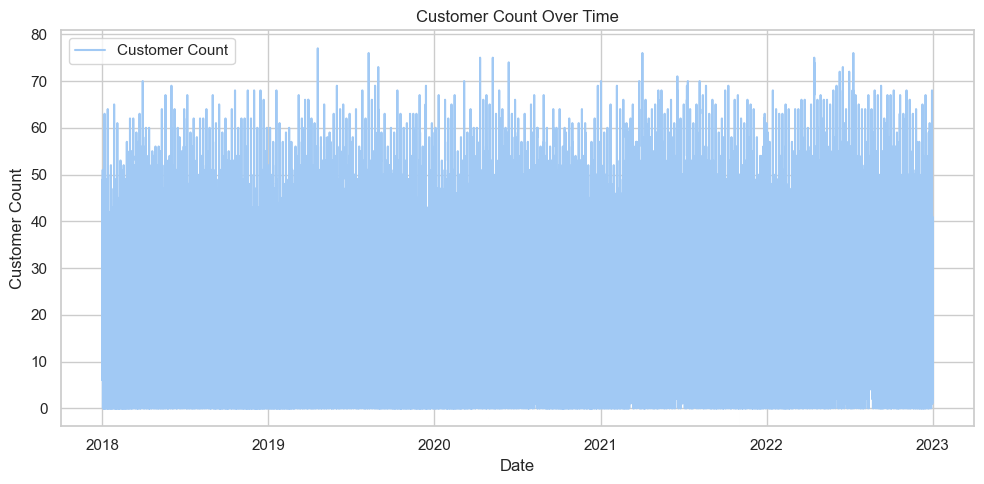

In [3]:
# 1. Time Series Plot: Customer Count Over Time
pastel_colors = sns.color_palette("pastel")
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['CustomerCount'], 
         label='Customer Count', 
         color=pastel_colors[0])  # Uses the first pastel color
plt.title("Customer Count Over Time")
plt.xlabel("Date")
plt.ylabel("Customer Count")
plt.legend()
plt.tight_layout()
plt.show()

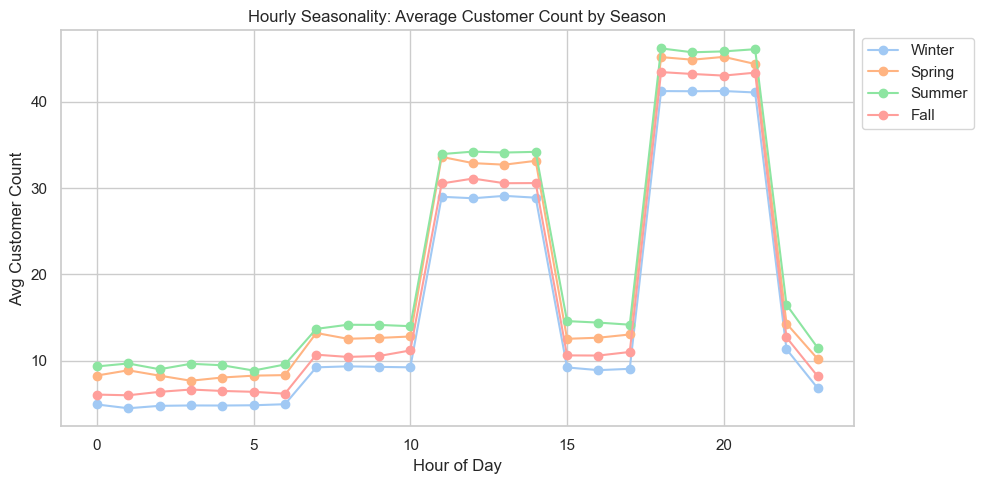

In [4]:
#2. Calculate hourly averages grouped by season
hourly_avg = df.groupby(['Season', df.index.hour])['CustomerCount'].mean().reset_index()
hourly_avg.columns = ['Season', 'Hour', 'AvgCustomerCount']

# Define the order of seasons and assign pastel colors
seasons_order = ['Winter', 'Spring', 'Summer', 'Fall']
colors = sns.color_palette("pastel", len(seasons_order))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

for i, season in enumerate(seasons_order):
    season_data = hourly_avg[hourly_avg['Season'] == season]
    ax.plot(season_data['Hour'], season_data['AvgCustomerCount'],
            marker='o',
            color=colors[i],
            label=season)

ax.set_title("Hourly Seasonality: Average Customer Count by Season")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Avg Customer Count")
ax.grid(True)
ax.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

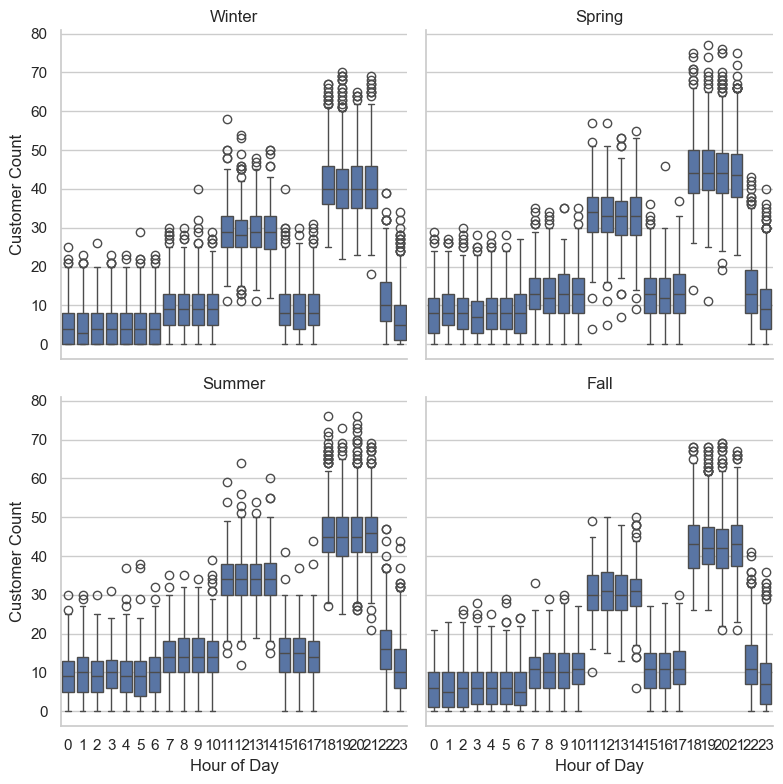

In [5]:
#3. Seasonal or Monthly Subplots
df['Hour'] = df.index.hour

# Create a FacetGrid of box plots for each season
plt.figure(figsize=(12, 6))
g = sns.FacetGrid(df, col="Season", col_wrap=2, height=4, sharey=True)
g.map_dataframe(sns.boxplot, x="Hour", y="CustomerCount", order=sorted(df['Hour'].unique()))
g.set_axis_labels("Hour of Day", "Customer Count")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()


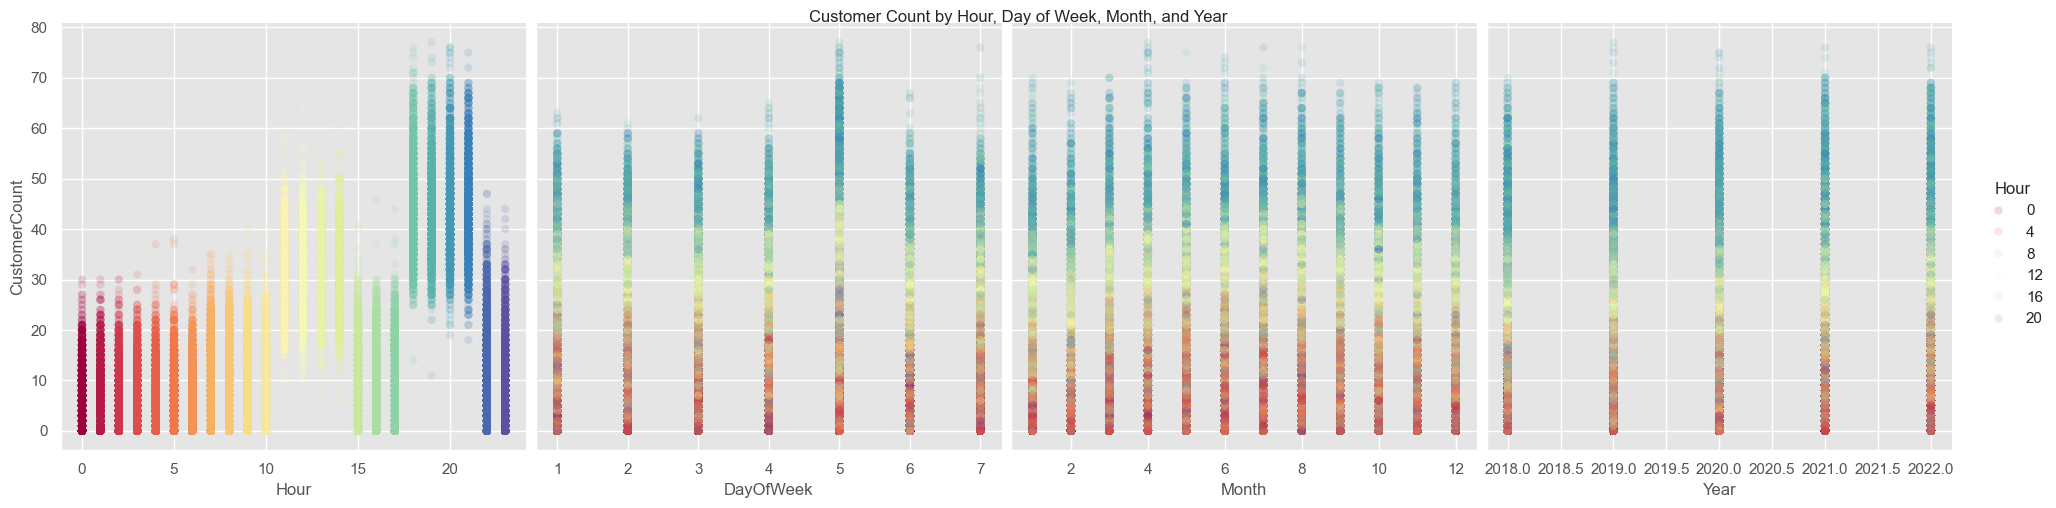

In [6]:
#4. Multiple scatter plots for hours, week, month and year
# Optionally set a style for a grid-like background
plt.style.use('ggplot')

# Get all unique hour values, sorted
hour_values = sorted(df['Hour'].unique())

sns.pairplot(
    data=df.dropna(subset=['Hour', 'DayOfWeek', 'Month', 'Year', 'CustomerCount']),
    hue='Hour',                # Uses the original 'Hour' column
    hue_order=hour_values,     # Force Seaborn to treat Hour as discrete categories
    palette='Spectral',        # Vibrant color palette
    x_vars=['Hour', 'DayOfWeek', 'Month', 'Year'],
    y_vars=['CustomerCount'],
    height=5,
    plot_kws={'alpha': 0.15, 'linewidth': 0}  # style settings
)

plt.suptitle('Customer Count by Hour, Day of Week, Month, and Year', y=1)
plt.show()

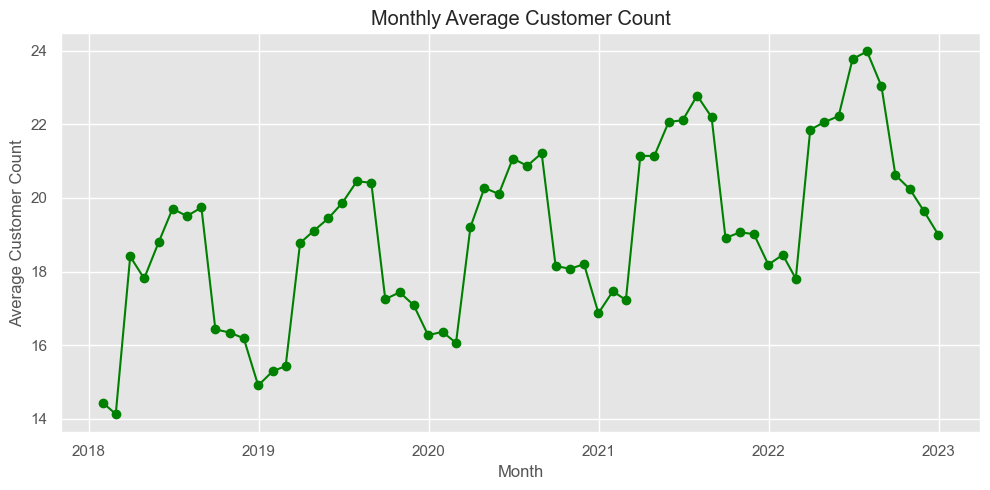

In [7]:
# 5. Monthly Average Customer Count
monthly_avg = df['CustomerCount'].resample('ME').mean()
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg.index, monthly_avg, marker='o', color='green')
plt.title("Monthly Average Customer Count")
plt.xlabel("Month")
plt.ylabel("Average Customer Count")
plt.tight_layout()
plt.show()

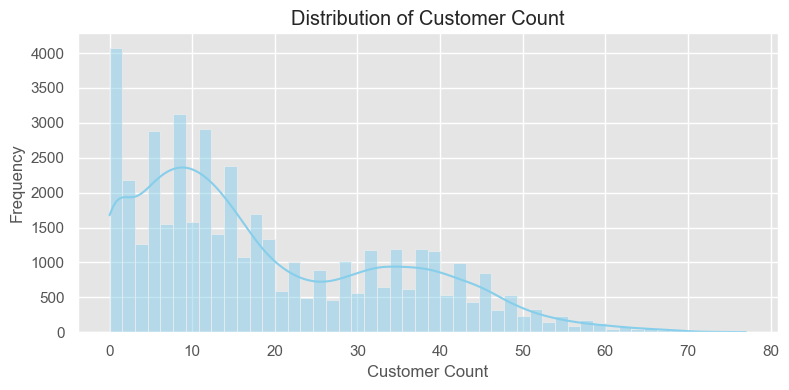

In [8]:
# 6. Distribution of Customer Count (Histogram)
plt.figure(figsize=(8, 4))
sns.histplot(df['CustomerCount'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Customer Count")
plt.xlabel("Customer Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

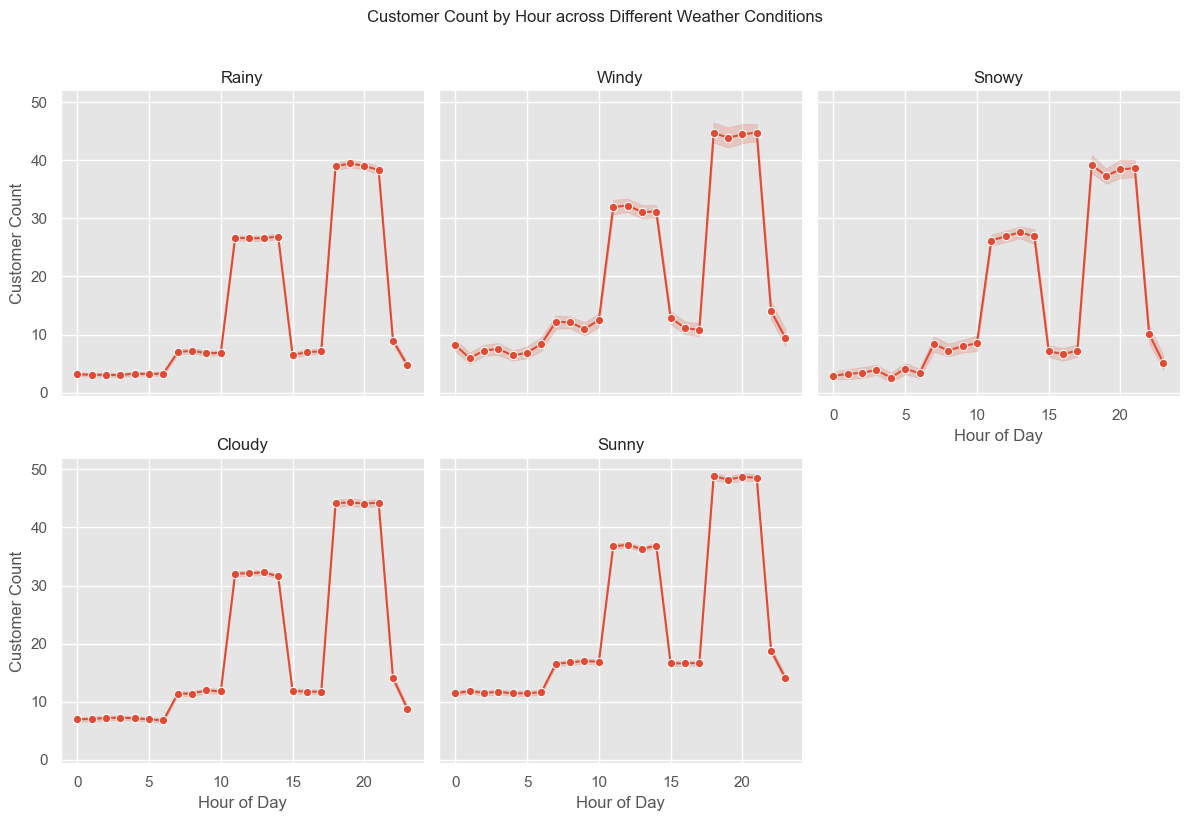

In [9]:
# 7. Facet Grid for Weather (Hour of the Day)
#Directly reflects when customer counts spike (e.g., lunch, dinner, or breakfast rushes).

g = sns.FacetGrid(df, col='Weather', col_wrap=3, height=4, sharey=True)
g.map(sns.lineplot, 'Hour', 'CustomerCount', marker='o')
g.set_titles("{col_name}")
g.set_axis_labels("Hour of Day", "Customer Count")
plt.suptitle("Customer Count by Hour across Different Weather Conditions", y=1.02)
plt.tight_layout()
plt.show()

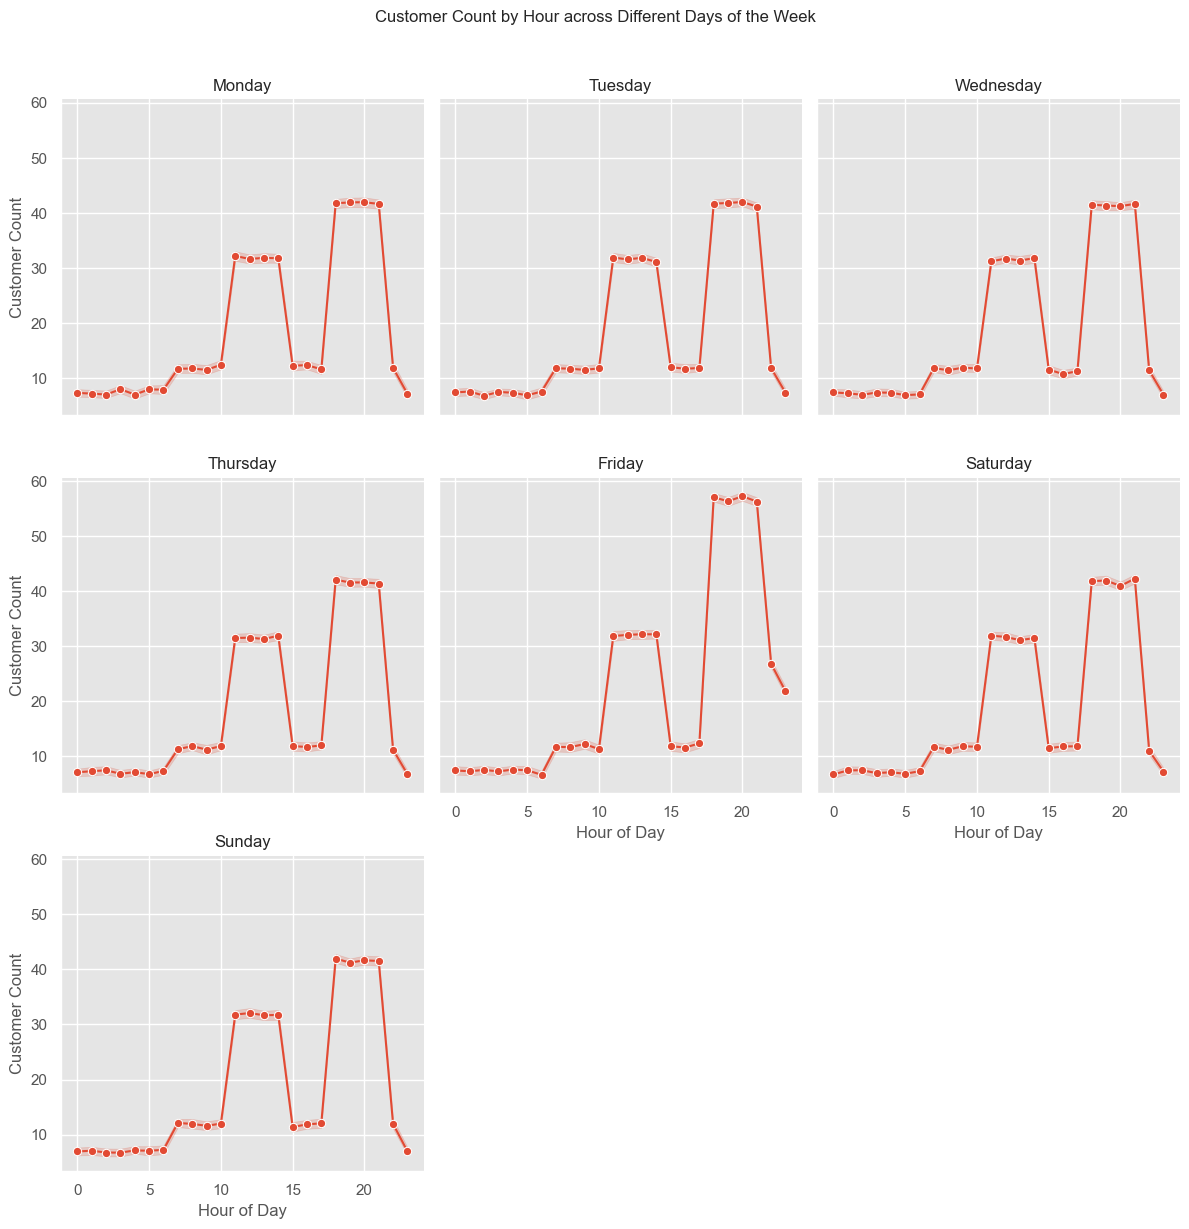

In [10]:
#8. FacetGrid to visualize how customer count varies by hour across each day of the week (Hour of the Day)
weekdays_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df['WeekDay'] = pd.Categorical(df['WeekDay'], categories=weekdays_order, ordered=True)

g = sns.FacetGrid(df, col='WeekDay', col_wrap=3, height=4, sharey=True)
g.map(sns.lineplot, 'Hour', 'CustomerCount', marker='o')
g.set_titles("{col_name}")
g.set_axis_labels("Hour of Day", "Customer Count")
plt.suptitle("Customer Count by Hour across Different Days of the Week", y=1.02)
plt.tight_layout()
plt.show()

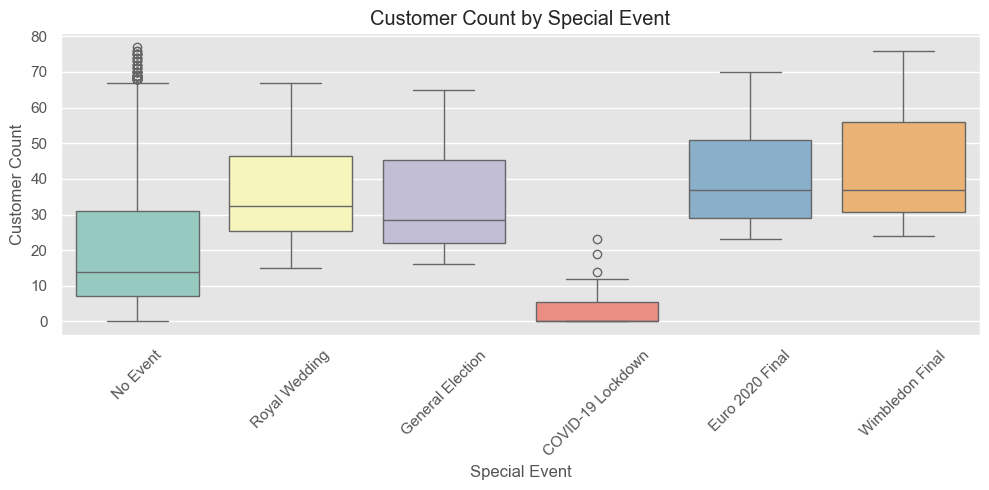

In [11]:
#9. Box plot to compare and examine the distribution of CustomerCount when there is a special event versus when there isn’t.
# Replace both None and NaN with "No Event"
df['SpecialEvent_filled'] = df['SpecialEvent'].replace({None: "No Event"}).fillna("No Event")

plt.figure(figsize=(10, 5))
sns.boxplot(x='SpecialEvent_filled', y='CustomerCount', hue='SpecialEvent_filled', data=df, palette="Set3")
plt.legend([],[], frameon=False) 
plt.xticks(rotation=45)
plt.title("Customer Count by Special Event")
plt.xlabel("Special Event")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()

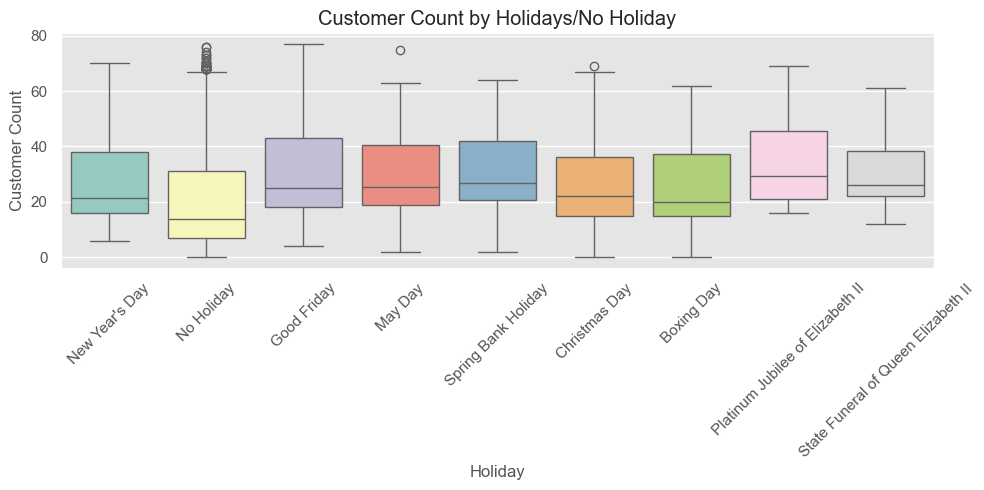

In [12]:
#10. Box plot to compare and examine the distribution of CustomerCount when there is Holiday versus when there isn’t.
# Holiday where it says None on the dataset replace them with "No Holiday"
holiday_mapping = {
    "New Year's Day (observed)": "New Year's Day",
    "Boxing Day (observed)": "Boxing Day",
    "Christmas Day (observed)": "Christmas Day",
    # Add more mappings as needed
}

# Replace holiday labels using the mapping
df['Holiday_merged'] = df['Holiday'].replace(holiday_mapping)

# Fill missing or None values with "No Holiday" (optional)
df['Holiday_merged'] = df['Holiday_merged'].replace({None: "No Holiday"}).fillna("No Holiday")

# Plot using the merged holiday labels
plt.figure(figsize=(10, 5))
sns.boxplot(x='Holiday_merged', y='CustomerCount', hue='Holiday_merged', data=df, palette="Set3")
plt.legend([], [], frameon=False)
plt.xticks(rotation=45)
plt.title("Customer Count by Holidays/No Holiday")
plt.xlabel("Holiday")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()

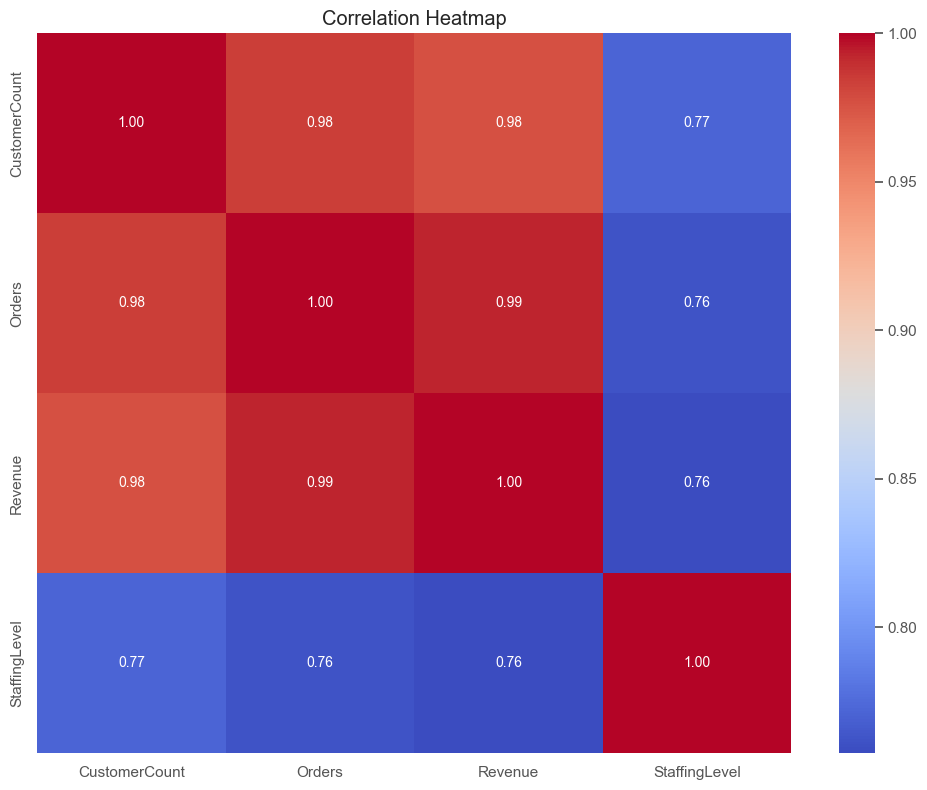

In [13]:
# 11. Correlation Heatmap for Key Numerical Features
plt.figure(figsize=(10, 8))
sns.heatmap(df[['CustomerCount', 'Orders', 'Revenue', 'StaffingLevel']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


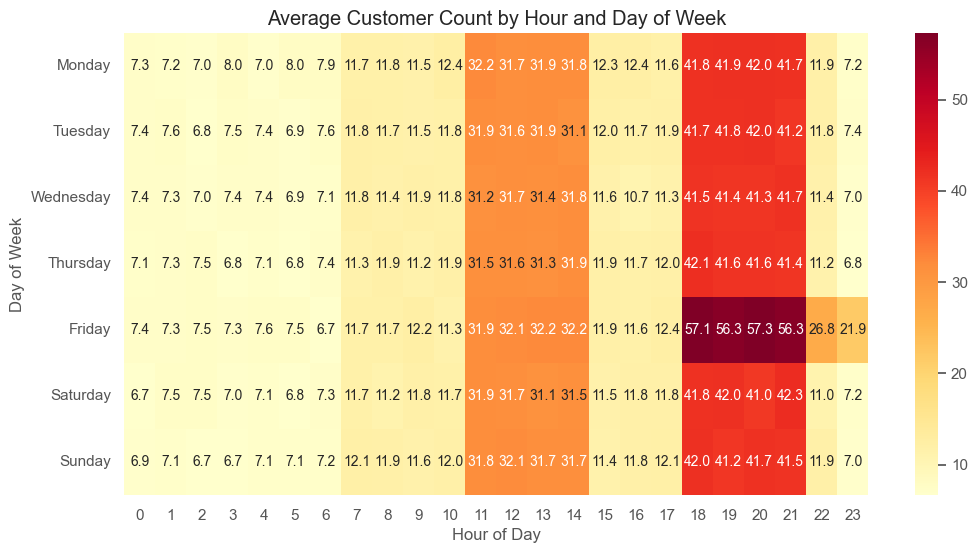

In [14]:
#12. HeathMap extra. Heatmap to display the average customer count for each hour across different days or days of the week. This can reveal patterns such as weekend spikes or weekday 
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.day_name()  # e.g., 'Monday', 'Tuesday', etc.

# Create a pivot table: rows = DayOfWeek, columns = Hour, values = average CustomerCount
pivot_table = df.pivot_table(index='DayOfWeek', columns='Hour', values='CustomerCount', aggfunc='mean')

# Optional: Reorder the days of the week for clarity
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(days_order)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt=".1f")
plt.title('Average Customer Count by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

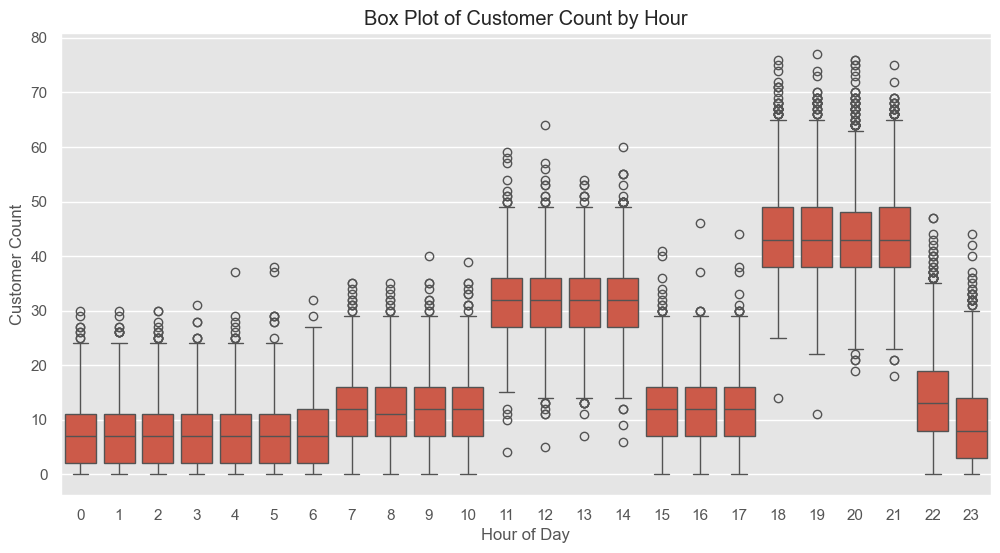

In [15]:
#13. Box Plots by Hour
df['Hour'] = df.index.hour

# Create a box plot of CustomerCount by Hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='CustomerCount', data=df)
plt.title('Box Plot of Customer Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Customer Count')
plt.show()

In [19]:
# THIS IS JUST FOR TESTING - REMOVE IT LATER
#  Define the split date
split_date = '2022-01-01'

# Call the function
restaurant_train, restaurant_test = split_train_test(df, split_date)

# Check their shapes
print("Training set shape:", restaurant_train.shape)
print("Test set shape:", restaurant_test.shape)

# Check the date ranges
print("Train start:", restaurant_train.index.min(), "→ Train end:", restaurant_train.index.max())
print("Test start:", restaurant_test.index.min(), "→ Test end:", restaurant_test.index.max())

Training set shape: (35064, 15)
Test set shape: (8760, 15)
Train start: 2018-01-01 00:00:00 → Train end: 2021-12-31 23:00:00
Test start: 2022-01-01 00:00:00 → Test end: 2022-12-31 23:00:00


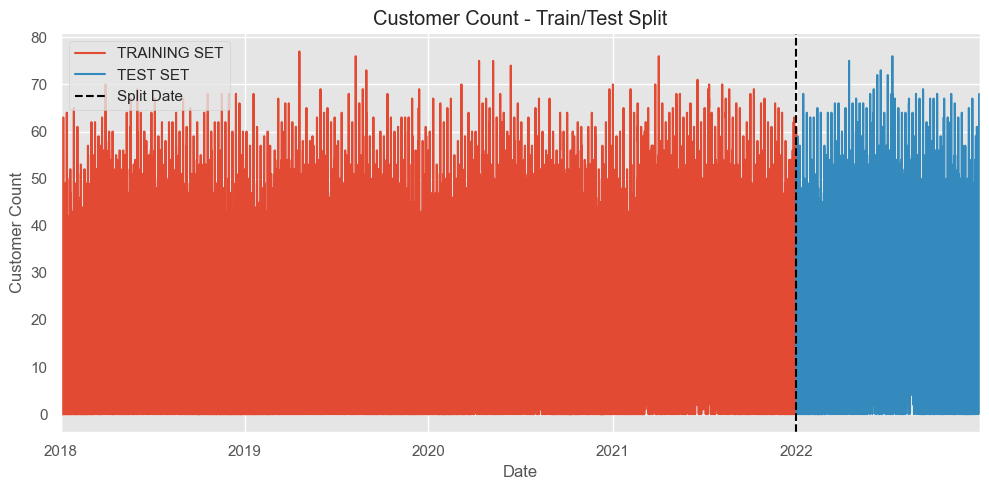

In [20]:
# Define your split datez
split_date = '2022-01-01'
restaurant_train, restaurant_test = split_train_test(df, split_date)

restaurant_train_renamed = restaurant_train[['CustomerCount']].rename(columns={'CustomerCount': 'TRAINING SET'})
restaurant_test_renamed = restaurant_test[['CustomerCount']].rename(columns={'CustomerCount': 'TEST SET'})

combined = pd.concat([restaurant_train_renamed, restaurant_test_renamed], axis=1)

combined.plot(figsize=(10, 5), title='Customer Count - Train/Test Split', style='-', ms=1)
plt.xlabel("Date")
plt.ylabel("Customer Count")
plt.axvline(split_date, color='black', ls='--', label='Split Date')
plt.legend()
plt.tight_layout()
plt.show()

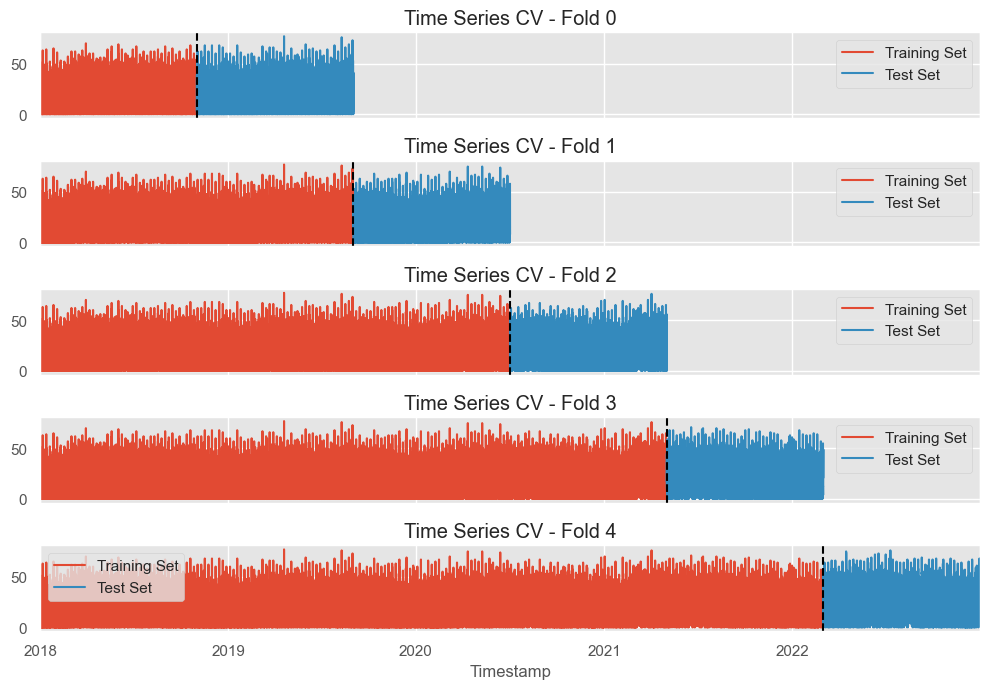

In [21]:
# Time Series Cross Validation Plot
n_splits = 5

# Create subplots
fig, axs = plt.subplots(nrows=n_splits, ncols=1, figsize=(10, 7), sharex=True)

# Use the generator to loop over folds
for fold, (train, test) in enumerate(generate_time_series_splits(df, n_splits=n_splits)):
    # Plot training set
    train['CustomerCount'].plot(ax=axs[fold], label='Training Set', title=f'Time Series CV - Fold {fold}')
    
    # Plot test set
    test['CustomerCount'].plot(ax=axs[fold], label='Test Set')
    
    # Vertical line at test start
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    
    # Add legend
    axs[fold].legend()

# Final layout
plt.tight_layout()
plt.show()

In [23]:
# THIS IS JUST FOR TESTING - REMOVE IT LATER
# Run the generator and print the fold sizes
for i, (train, test) in enumerate(generate_time_series_splits(df, n_splits=5)):
    print(f"Fold {i}:")
    print(f"  Train range: {train.index.min()} → {train.index.max()}, shape = {train.shape}")
    print(f"  Test  range: {test.index.min()} → {test.index.max()}, shape = {test.shape}")
    print("-" * 50)

Fold 0:
  Train range: 2018-01-01 00:00:00 → 2018-11-01 07:00:00, shape = (7304, 15)
  Test  range: 2018-11-01 08:00:00 → 2019-09-01 15:00:00, shape = (7304, 15)
--------------------------------------------------
Fold 1:
  Train range: 2018-01-01 00:00:00 → 2019-09-01 15:00:00, shape = (14608, 15)
  Test  range: 2019-09-01 16:00:00 → 2020-07-01 23:00:00, shape = (7304, 15)
--------------------------------------------------
Fold 2:
  Train range: 2018-01-01 00:00:00 → 2020-07-01 23:00:00, shape = (21912, 15)
  Test  range: 2020-07-02 00:00:00 → 2021-05-02 07:00:00, shape = (7304, 15)
--------------------------------------------------
Fold 3:
  Train range: 2018-01-01 00:00:00 → 2021-05-02 07:00:00, shape = (29216, 15)
  Test  range: 2021-05-02 08:00:00 → 2022-03-02 15:00:00, shape = (7304, 15)
--------------------------------------------------
Fold 4:
  Train range: 2018-01-01 00:00:00 → 2022-03-02 15:00:00, shape = (36520, 15)
  Test  range: 2022-03-02 16:00:00 → 2022-12-31 23:00:00, s